# Baseline Linear Regression

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# two levels up from the notebook to project root, then append to sys.path
sys.path.append(str(Path().resolve().parents[1]))

PROJECT_ROOT = Path().resolve().parents[1]
RESULTS_PATH = PROJECT_ROOT / "results"


from utils.data_loading import load_datasets
from utils.data_preparation import get_spo2_to_po2_interpolator, add_shift_raw_column, add_engineered_features
from utils.evaluation import evaluate_macro_patient_level, print_evaluation, bland_altman_plots, bland_altman_pct_comparison
from utils.modeling import fit_cv_models, predict_cv_ensemble
from utils.logging import log_run_json


train_df, test_df, val_df, odc = load_datasets()
spo2_to_po2 = get_spo2_to_po2_interpolator(odc)

train_df = add_shift_raw_column(train_df, spo2_to_po2)
test_df  = add_shift_raw_column(test_df, spo2_to_po2)
val_df   = add_shift_raw_column(val_df, spo2_to_po2)

In [14]:
from sklearn.linear_model import LinearRegression

In [ ]:
train_df_engineered = add_engineered_features(train_df, spo2_to_po2)
test_df_engineered = add_engineered_features(test_df, spo2_to_po2)
val_df_engineered = add_engineered_features(val_df, spo2_to_po2)

features = ['shift_raw', 'log_PiO2', 'SpO2_squared', 'saturation_deficit']

# Train ensemble of CV models
cv_models = fit_cv_models(
    train_df,
    features=features,
    target_col='shift',
    model_class=LinearRegression,
    k=10
)

# Predict on test set (average over CV models)
test_df['y_pred'] = predict_cv_ensemble(test_df, features, cv_models)

# Evaluate macro-averaged patient metrics
test_summary = evaluate_macro_patient_level(test_df, y_true_col='shift', y_pred_col='y_pred')
print_evaluation(test_summary)


Macro-averaged per-patient metrics:
MAE  = 0.891
MSE  = 1.737
RMSE = 1.082
Mean Bias Error = 0.025
MAPE = 8.589%
nRMSE = 5.754%


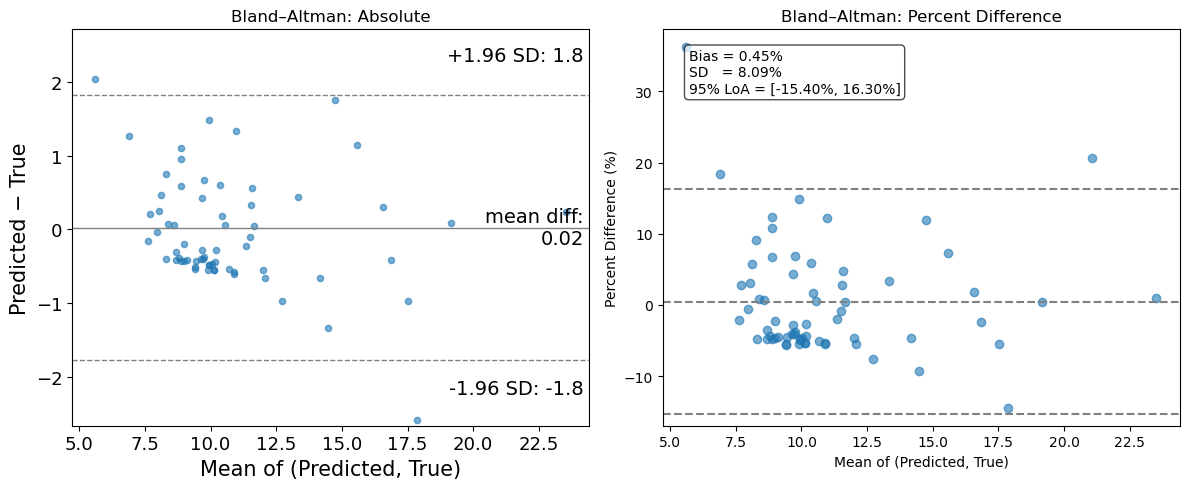

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'Bland–Altman: Absolute'}, xlabel='Mean of (Predicted, True)', ylabel='Predicted − True'>,
        <Axes: title={'center': 'Bland–Altman: Percent Difference'}, xlabel='Mean of (Predicted, True)', ylabel='Percent Difference (%)'>],
       dtype=object))

In [16]:
bland_altman_plots(test_df, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')


## Val Statistics

Macro-averaged per-patient metrics:
MAE  = 1.134
MSE  = 3.139
RMSE = 1.383
Mean Bias Error = 0.195
MAPE = 9.353%
nRMSE = 7.090%


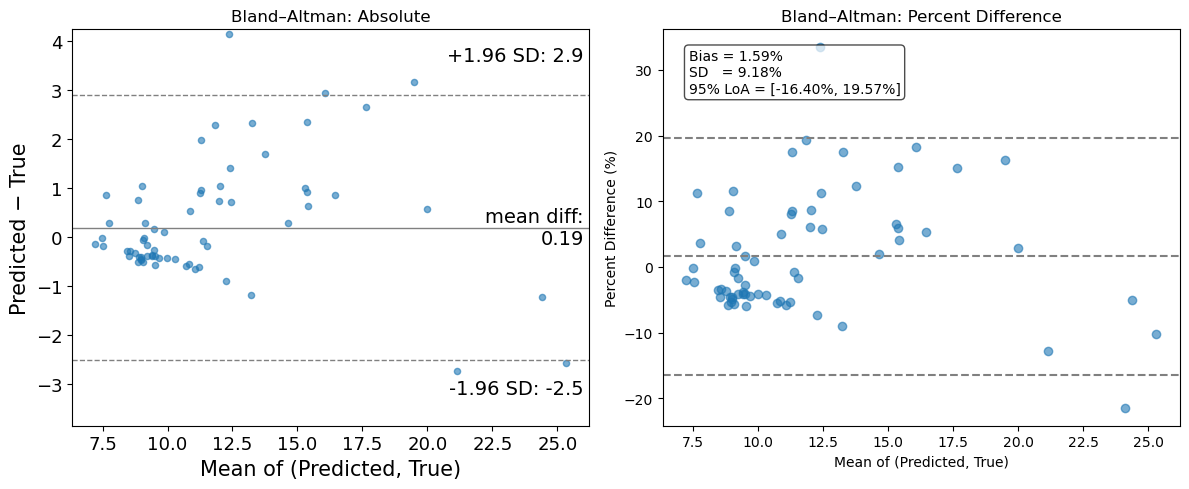

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'Bland–Altman: Absolute'}, xlabel='Mean of (Predicted, True)', ylabel='Predicted − True'>,
        <Axes: title={'center': 'Bland–Altman: Percent Difference'}, xlabel='Mean of (Predicted, True)', ylabel='Percent Difference (%)'>],
       dtype=object))

In [17]:
val_df['y_pred'] = predict_cv_ensemble(val_df, features, cv_models)

val_summary = evaluate_macro_patient_level(val_df, y_true_col='shift', y_pred_col='y_pred')
print_evaluation(val_summary)

bland_altman_plots(val_df, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')


## Comparison Bland-Altman

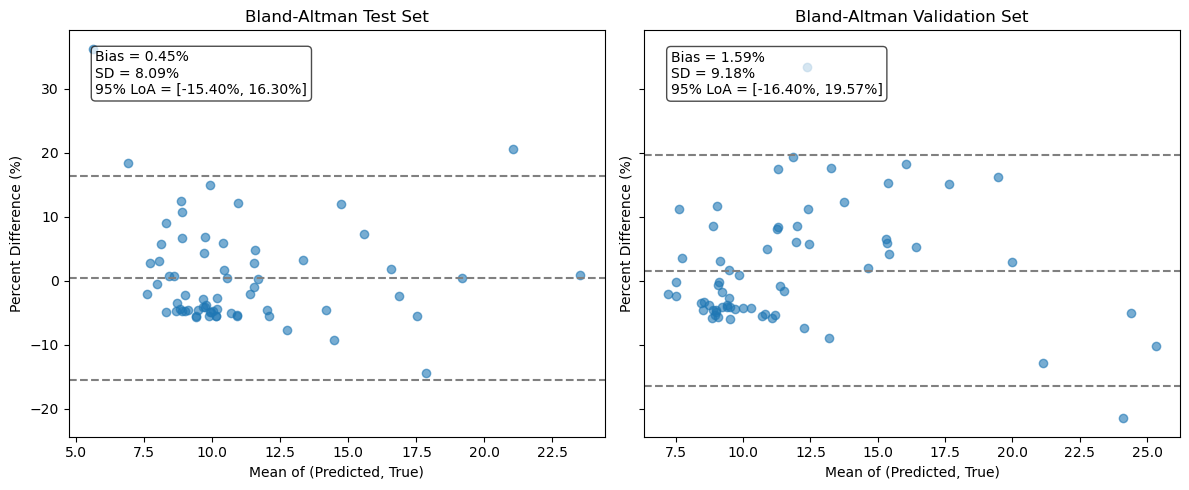

In [18]:
fig, axs = bland_altman_pct_comparison(test_df, val_df, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')


## Logging

In [ ]:
description = f'''
Model: Linear Regression Optimal features
Description: This is a model that is trained on the optimal features derived from combinatory exploration.
Features: shift_raw, log_PiO2, SpO2_squared, saturation_deficit
Target: shift
Notes: patient-level macro metrics, ODC from neonatal table
'''

# Filter only scalar (JSON-serializable) entries
json_test_metrics = {
    k: float(v) if isinstance(v, (np.generic, np.float64, np.float32)) else v
    for k, v in test_summary.items()
    if not isinstance(v, pd.Series)
}
json_val_metrics = {
    k: float(v) if isinstance(v, (np.generic, np.float64, np.float32)) else v
    for k, v in val_summary.items()
    if not isinstance(v, pd.Series)
}

json_path = RESULTS_PATH / "single_point_model_metrics_log.json"

log_run_json(
    identifier="Linear Regression Optimal features",
    model_type="Linear Regression",
    features=features,
    train_subset="full train set",
    test_subset="full test set",
    val_subset="full validation set",  
    description=description,
    test_metrics=json_test_metrics,
    val_metrics=json_val_metrics,

    json_path=json_path
)


✅ Logged run #2 ➜ /Users/sarah/Code/neonatal-odc-shift/results/single_point_model_metrics_log.json


# Subset Selection for Training

In [26]:
def evaluate_models_trained_on_subsets(train_df, test_df, val_df, features, subset_conditions):
    test_results = []
    val_results = []

    for name, condition in subset_conditions.items():
        train_subset = train_df[condition(train_df)].copy()
        if len(train_subset) == 0:
            continue

        # Train model on filtered training data
        cv_models = fit_cv_models(
            train_subset,
            features=features,
            target_col="shift",
            model_class=LinearRegression,
            k=10
        )

        # Predict and evaluate on full test set
        test_df_copy = test_df.copy()
        test_df_copy["y_pred"] = predict_cv_ensemble(test_df_copy, features, cv_models)
        test_summary = evaluate_macro_patient_level(test_df_copy, y_true_col="shift", y_pred_col="y_pred")

        test_results.append({
            "Subset (Train)": name,
            "N train patients": train_subset["Anon.Patient_ID"].nunique(),
            "N train rows": len(train_subset),
            "Test MAE": test_summary["MAE"],
            "Test MSE": test_summary["MSE"],
            "Test RMSE": test_summary["RMSE"],
            "Test Bias": test_summary["Mean Bias Error"],
            "Test MAPE": test_summary["MAPE"],
            "Test nRMSE": test_summary["nRMSE"]
        })

        # Predict and evaluate on full validation set
        val_df_copy = val_df.copy()
        val_df_copy["y_pred"] = predict_cv_ensemble(val_df_copy, features, cv_models)
        val_summary = evaluate_macro_patient_level(val_df_copy, y_true_col="shift", y_pred_col="y_pred")

        val_results.append({
            "Subset (Train)": name,
            "N train patients": train_subset["Anon.Patient_ID"].nunique(),
            "N train rows": len(train_subset),
            "Val MAE": val_summary["MAE"],
            "Val MSE": val_summary["MSE"],
            "Val RMSE": val_summary["RMSE"],
            "Val Bias": val_summary["Mean Bias Error"],
            "Val MAPE": val_summary["MAPE"],
            "Val nRMSE": val_summary["nRMSE"]
        })

    test_df_result = pd.DataFrame(test_results).sort_values("Test MAE").reset_index(drop=True)
    val_df_result = pd.DataFrame(val_results).sort_values("Val MAE").reset_index(drop=True)

    return test_df_result, val_df_result

# Usage:
test_results_df, val_results_df = evaluate_models_trained_on_subsets(
    train_df=train_df,
    test_df=test_df,
    val_df=val_df,
    features=features,
    subset_conditions=subset_conditions
)

display(test_results_df)
display(val_results_df)


,Subset (Train),N train patients,N train rows,Test MAE,Test MSE,Test RMSE,Test Bias,Test MAPE,Test nRMSE
0,PiO2 < 25,147,991,0.869246,1.510378,1.040397,-0.086669,8.411755,5.531780
1,PiO2 < 30,151,1083,0.870640,1.500989,1.046403,-0.059467,8.455523,5.563714
2,PiO2 < 21,132,858,0.900109,1.602031,1.053201,-0.189665,8.571240,5.599863
3,SpO2 < 95,152,693,1.080292,3.486944,1.373005,-0.068767,10.098164,7.300255
4,SpO2 < 92.5,152,446,1.233694,4.253202,1.563503,-0.298181,11.572833,8.313129
5,SpO2 < 90,140,248,1.420728,5.696468,1.807939,-0.459106,13.392366,9.612793
6,PiO2 > 21,57,273,1.531142,3.897473,1.803572,-0.875710,14.778026,9.589575


,Subset (Train),N train patients,N train rows,Val MAE,Val MSE,Val RMSE,Val Bias,Val MAPE,Val nRMSE
0,PiO2 < 21,132,858,1.076395,3.207224,1.266305,-0.172967,8.352491,6.493871
1,PiO2 < 25,147,991,1.079040,3.022651,1.287604,-0.011445,8.598345,6.603100
2,PiO2 < 30,151,1083,1.091866,2.991549,1.302693,0.033685,8.774610,6.680475
3,SpO2 < 95,152,693,1.419805,5.322659,1.855390,0.154823,12.026718,9.514823
4,SpO2 < 92.5,152,446,1.569859,6.191194,2.052127,-0.049786,13.479546,10.523728
5,PiO2 > 21,57,273,1.649064,4.563397,1.952147,-0.604969,14.705224,10.011012
6,SpO2 < 90,140,248,1.787979,8.175455,2.356585,-0.160999,15.529547,12.085051


# Subset Selection for Testing

In [23]:
subset_conditions = {
    "SpO2 < 95": lambda df: df["SpO2(%)"] < 95,
    "SpO2 < 92.5": lambda df: df["SpO2(%)"] < 92.5,
    "SpO2 < 90": lambda df: df["SpO2(%)"] < 90,
    "PiO2 < 30": lambda df: df["PiO2(kPa)"] < 30,
    "PiO2 < 25": lambda df: df["PiO2(kPa)"] < 25,
    "PiO2 < 21": lambda df: df["PiO2(kPa)"] < 21,
    "PiO2 > 21": lambda df: df["PiO2(kPa)"] > 21,
}

# Function to evaluate and collect results, sorted by MAE
def evaluate_subsets(df, df_name, cv_models, features, subset_conditions):
    results = []
    for name, condition in subset_conditions.items():
        subset = df[condition(df)].copy()
        if len(subset) == 0:
            continue
        subset["y_pred"] = predict_cv_ensemble(subset, features, cv_models)
        summary = evaluate_macro_patient_level(subset, y_true_col="shift", y_pred_col="y_pred")
        row = {
            "Subset": name,
            "N patients": subset["Anon.Patient_ID"].nunique(),
            "N rows": len(subset),
            "MAE": summary["MAE"],
            "RMSE": summary["RMSE"],
            "Mean Bias Error": summary["Mean Bias Error"],
            "MAPE": summary["MAPE"],
            "nRMSE": summary["nRMSE"]
        }
        results.append(row)
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="MAE").reset_index(drop=True)
    return results_df

# Run and sort results
test_results_df = evaluate_subsets(test_df, "Test", cv_models, features, subset_conditions)
val_results_df = evaluate_subsets(val_df, "Validation", cv_models, features, subset_conditions)

# Display
display(test_results_df)
display(val_results_df)
# Optionally save
# test_results_df.to_csv("test_subset_results.csv", index=False)
# val_results_df.to_csv("val_subset_results.csv", index=False)


,Subset,N patients,N rows,MAE,RMSE,Mean Bias Error,MAPE,nRMSE
0,SpO2 < 92.5,65,187,0.609935,0.694117,0.181825,5.609907,4.050244
1,SpO2 < 90,63,115,0.641670,0.688524,0.281151,5.668284,4.017606
2,PiO2 < 21,58,376,0.722138,0.867485,-0.035605,8.460364,8.213887
3,SpO2 < 95,66,304,0.739839,0.872012,0.104594,6.959690,4.636479
4,PiO2 < 25,63,428,0.793000,0.941574,-0.119579,8.324088,6.468183
5,PiO2 < 30,65,468,0.797948,0.964430,-0.081347,8.238937,6.625193
6,PiO2 > 21,21,119,1.285829,1.487965,0.226114,8.994457,11.345112


,Subset,N patients,N rows,MAE,RMSE,Mean Bias Error,MAPE,nRMSE
0,SpO2 < 90,55,60,0.515128,0.519056,0.179886,4.509712,2.916045
1,PiO2 < 21,54,197,0.602539,0.709024,-0.052244,6.157942,9.208107
2,SpO2 < 92.5,66,112,0.689302,0.719331,0.016379,5.358337,3.688875
3,PiO2 < 25,60,233,0.696693,0.835063,0.049450,6.868098,9.176516
4,SpO2 < 95,66,182,0.786201,0.883169,0.015101,6.466925,4.529074
5,PiO2 < 30,63,257,0.832310,1.007645,0.109333,7.725367,6.585914
6,PiO2 > 21,31,101,2.258475,2.518896,1.254815,15.595007,13.840089


# Subset Selection for Training and Testing

In [32]:
def evaluate_models_on_matched_subsets(train_df, test_df, val_df, features, subset_conditions):
    test_results = []
    val_results = []

    for name, condition in subset_conditions.items():
        train_subset = train_df[condition(train_df)].copy()
        test_subset = test_df[condition(test_df)].copy()
        val_subset = val_df[condition(val_df)].copy()

        if len(train_subset) == 0 or len(test_subset) == 0 or len(val_subset) == 0:
            continue

        # Train model on filtered training data
        cv_models = fit_cv_models(
            train_subset,
            features=features,
            target_col="shift",
            model_class=LinearRegression,
            k=10
        )

        # Predict and evaluate on filtered test set
        test_subset["y_pred"] = predict_cv_ensemble(test_subset, features, cv_models)
        test_summary = evaluate_macro_patient_level(test_subset, y_true_col="shift", y_pred_col="y_pred")

        test_results.append({
            "Subset": name,
            "N train patients": train_subset["Anon.Patient_ID"].nunique(),
            "N train rows": len(train_subset),
            "N test patients": test_subset["Anon.Patient_ID"].nunique(),
            "N test rows": len(test_subset),
            "Test MAE": test_summary["MAE"],
            "Test MSE": test_summary["MSE"],
            "Test RMSE": test_summary["RMSE"],
            "Test Bias": test_summary["Mean Bias Error"],
            "Test MAPE": test_summary["MAPE"],
            "Test nRMSE": test_summary["nRMSE"]
        })

        # Predict and evaluate on filtered val set
        val_subset["y_pred"] = predict_cv_ensemble(val_subset, features, cv_models)
        val_summary = evaluate_macro_patient_level(val_subset, y_true_col="shift", y_pred_col="y_pred")

        val_results.append({
            "Subset": name,
            "N train patients": train_subset["Anon.Patient_ID"].nunique(),
            "N train rows": len(train_subset),
            "N val patients": val_subset["Anon.Patient_ID"].nunique(),
            "N val rows": len(val_subset),
            "Val MAE": val_summary["MAE"],
            "Val MSE": val_summary["MSE"],
            "Val RMSE": val_summary["RMSE"],
            "Val Bias": val_summary["Mean Bias Error"],
            "Val MAPE": val_summary["MAPE"],
            "Val nRMSE": val_summary["nRMSE"]
        })

    test_df_result = pd.DataFrame(test_results).sort_values("Test MAE").reset_index(drop=True)
    val_df_result = pd.DataFrame(val_results).sort_values("Val MAE").reset_index(drop=True)
    return test_df_result, val_df_result


# Run it
test_results_df, val_results_df = evaluate_models_on_matched_subsets(
    train_df, test_df, val_df, features, subset_conditions
)

display(test_results_df)
display(val_results_df)


,Subset,N train patients,N train rows,N test patients,N test rows,Test MAE,Test MSE,Test RMSE,Test Bias,Test MAPE,Test nRMSE
0,SpO2 < 90,140,248,63,115,0.589302,0.704348,0.650504,0.161161,5.311813,3.795755
1,SpO2 < 92.5,152,446,65,187,0.644700,1.452656,0.744797,0.150680,6.074985,4.345965
2,PiO2 < 21,132,858,58,376,0.709625,0.900088,0.835571,-0.068565,8.182005,7.911711
3,PiO2 < 25,147,991,63,428,0.812874,1.166207,0.949078,-0.158136,8.262221,6.519729
4,SpO2 < 95,152,693,66,304,0.819252,2.270360,0.982710,0.185532,7.559594,5.225061
5,PiO2 < 30,151,1083,65,468,0.821745,1.195042,0.976278,-0.126277,8.348298,6.706578
6,PiO2 > 21,57,273,21,119,1.726572,5.502409,1.980020,-0.269669,10.734622,15.096827


,Subset,N train patients,N train rows,N val patients,N val rows,Val MAE,Val MSE,Val RMSE,Val Bias,Val MAPE,Val nRMSE
0,SpO2 < 90,140,248,55,60,0.317505,0.181750,0.320455,0.050333,2.922516,1.800308
1,SpO2 < 92.5,152,446,66,112,0.518135,0.661995,0.557764,0.019706,4.422056,2.860329
2,PiO2 < 21,132,858,54,197,0.541149,0.523661,0.635956,-0.096398,5.396624,8.259167
3,PiO2 < 25,147,991,60,233,0.637596,0.757004,0.765853,0.006922,6.310656,8.415972
4,SpO2 < 95,152,693,66,182,0.743727,1.821568,0.866531,0.150422,6.489703,4.443748
5,PiO2 < 30,151,1083,63,257,0.798701,1.339766,0.960071,0.050043,7.258605,6.274976
6,PiO2 > 21,57,273,31,101,1.950713,6.377477,2.197464,0.759247,14.000015,12.073977


In [35]:
metrics_to_round = [
    "Test MAE", "Test MSE", "Test RMSE", "Test Bias",
    "Val MAE", "Val MSE", "Val RMSE", "Val Bias"
]
merged_df[metrics_to_round] = merged_df[metrics_to_round].round(3)

output_path = RESULTS_PATH / "linear_regression_subset_metrics_train_test.csv"
merged_df.to_csv(output_path, index=False)
